# COMP90049_Project2


## Data Analysis


In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

In [2]:
train_labels = pd.read_csv("./dataset/train_labels.csv")
train_features = pd.read_csv("./dataset/train_features.csv")
valid_labels = pd.read_csv("./dataset/valid_labels.csv")
valid_features = pd.read_csv("./dataset/valid_features.csv")
test_features = pd.read_csv("./dataset/test_features.csv")

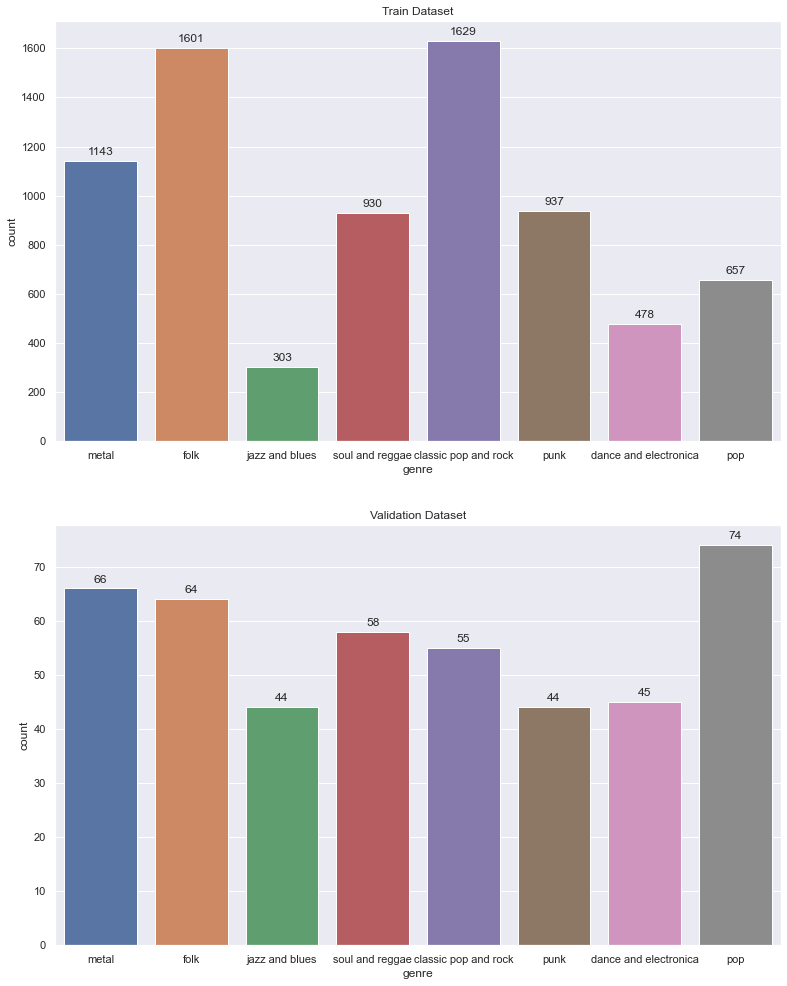

In [3]:
## Distribution of classes in Train Dataset and Validation Dataset

plt.figure(1,figsize=(13,17))
plt.subplot(2,1,1)
cp1 = sns.countplot(train_labels['genre'], order = ['metal', 'folk', 'jazz and blues', 'soul and reggae',
       'classic pop and rock', 'punk', 'dance and electronica', 'pop'])
for p in cp1.patches:
       cp1.annotate(format(p.get_height(), 'd'), 
              (p.get_x() + p.get_width() / 2., p.get_height()), 
              ha = 'center', va = 'center', 
              xytext = (0, 9), 
              textcoords = 'offset points')
plt.title('Train Dataset')

plt.subplot(2,1,2)
cp2 = sns.countplot(valid_labels['genre'], order = ['metal', 'folk', 'jazz and blues', 'soul and reggae',
       'classic pop and rock', 'punk', 'dance and electronica', 'pop'])
for p in cp2.patches:
       cp2.annotate(format(p.get_height(), 'd'), 
              (p.get_x() + p.get_width() / 2., p.get_height()), 
              ha = 'center', va = 'center', 
              xytext = (0, 9), 
              textcoords = 'offset points')
plt.title('Validation Dataset')
plt.show()

## Predict Music Genre from Lyrics


In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import classification_report

In [5]:
nb_weights = compute_sample_weight(class_weight='balanced', y = train_labels['genre'])      ## sample_weight of Naive Bayes Classifier


vect = TfidfVectorizer(
        max_df=0.25, # ignore terms that appear in more than 25% of lyrics
        min_df=4)   # ignore terms that appear in less than 4 of lyrics

tfdif = vect.fit(train_features['tags'])
train_lyrics = tfdif.transform(train_features['tags'])
valid_lyrics = tfdif.transform(valid_features['tags'])                      ## bag-of-words


def train(tag, X = train_lyrics, y = train_labels['genre'], nb_weights = nb_weights):       ## choose specific classifier and fit dataset

    if tag == 'bnb':        
        clf = BernoulliNB()
    
    elif tag == 'gnb':  
        clf = GaussianNB()

    elif tag == 'mnb':  
        clf = MultinomialNB()

    elif tag == 'rdf':
        clf = RandomForestClassifier(class_weight = 'balanced', criterion = 'entropy', random_state = 25)

    elif tag == 'log':
        clf = LogisticRegression(solver='lbfgs', class_weight = 'balanced')

    elif tag == 'knn':
        clf = KNeighborsClassifier(n_neighbors=29)

    elif tag == 'mlp':
        clf = MLPClassifier(activation='relu', solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(300, 300, ))

    elif tag == 'zero':                     ##Zero-R
        clf = DummyClassifier(strategy="stratified")
    
    elif tag == 'vote':
        clf1 = train('mnb')
        clf2 = train('rdf')
        clf3 = train('log')
        clf = VotingClassifier(estimators=[
            ('mnb', clf1), ('rdf', clf2), ('log', clf3)],
            voting='soft')



    
    if tag in ['bnb, mnb']:
        clf.fit(X, y, sample_weight = nb_weights)
    else:
        clf.fit(X, y)

    return clf


In [6]:
def predict(X, clf):
    return clf.predict(X)

def evaluate(y, pred):                      ## evaluate the accuracy of each classifier
    return np.mean(y==pred)

In [7]:
def comparison_figure(Classifier, accuracy):                      ## Draw figures of comparison between classifiers
    plt.figure(1,figsize=(13,8.5))
    bp = sns.barplot(Classifier, accuracy)
    plt.xlabel('Classifier')
    plt.ylabel('Accuracy')
    plt.ylim(0,1)
    for p in bp.patches:
        bp.annotate(format(p.get_height(), '.3f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

Text(0, 0.5, 'Accuracy')

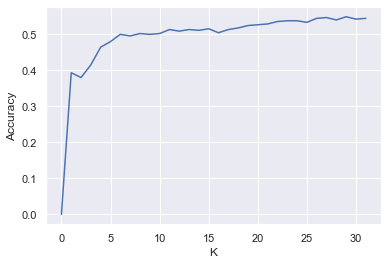

In [8]:
#### Choose best K in KNN --> finally, choose K=29 
K = [0]
Acc = [0]
for i in range (1,32):
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_lyrics, train_labels['genre'])
    pred = predict(valid_lyrics, clf)
    acc = evaluate(valid_labels['genre'], pred)
    K.append(i)
    Acc.append(acc)
plt.plot(K, Acc)
plt.xlabel('K')
plt.ylabel('Accuracy')

In [9]:
## Developed 8 algorithms, 'ZeroR', 'BernoulliNB', 'MultinomialNB', 'RandomForest', 'LogisticRegression','KNN', 'MultiLayerPerceptron','SoftVoting'

learners = ['zero', 'bnb', 'mnb', 'rdf', 'log', 'knn', 'mlp', 'vote']
accuracy=[]

for learner in learners:
    clf = train(learner)
    pred = predict(valid_lyrics, clf)
    acc = evaluate(valid_labels['genre'], pred)
    accuracy.append(acc)






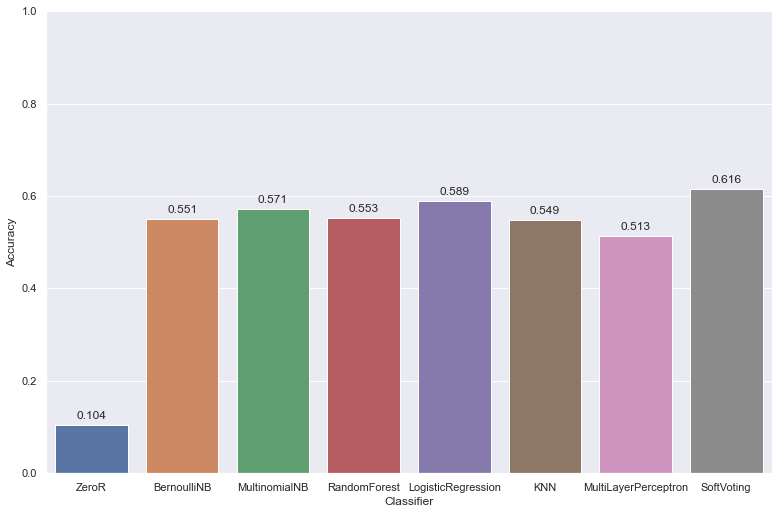

In [10]:
classifiers = ['ZeroR', 'BernoulliNB', 'MultinomialNB', 'RandomForest', 
               'LogisticRegression','KNN', 'MultiLayerPerceptron','SoftVoting']
comparison_figure(classifiers, accuracy)

## Predict Genre from Audio Features

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

####### Preprocessing

### Extrace all numric and audio-based features. Then have a comparison bewteen a standardized input and an original input.


std_scaler = StandardScaler()
train_features_aud = train_features.iloc[:, np.r_[3,4,8:157]]
valid_features_aud = valid_features.iloc[:, np.r_[3,4,8:157]]

train_features_std = std_scaler.fit_transform(train_features_aud)
valid_features_std = std_scaler.fit_transform(valid_features_aud)

<AxesSubplot:title={'center':'Distribution of vect_1 before Standardization'}, xlabel='vect_1', ylabel='Density'>

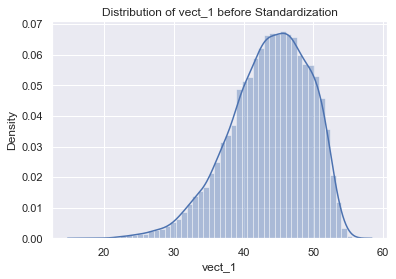

In [12]:
## Distribution of terms in vect column before stadardization
plt.title('Distribution of vect_1 before Standardization')
sns.distplot(train_features['vect_1'])

Text(0.5, 0, 'vect_1')

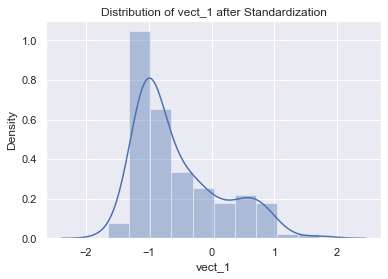

In [13]:
## Distribution of terms in vect column after standardization
sns.distplot(train_features_std[3])
plt.title('Distribution of vect_1 after Standardization')
plt.xlabel('vect_1')

In [14]:
def train(tag, X , y = train_labels['genre'], nb_weights = nb_weights):
    if tag == 'gnb':
        clf = GaussianNB()
        clf.fit(X,y,sample_weight=nb_weights)

    elif tag == 'knn':
        clf = KNeighborsClassifier(n_neighbors = 30)
        clf.fit(X,y)
    elif tag == 'mlp':
        clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(110, 110, ))
        clf.fit(X,y)
        
    return clf

In [15]:
def predict(X, text_clf):
    return text_clf.predict(X)

def evaluate(y, pred):                          ## evaluate the accuracy of each classifier
    return np.mean(y==pred)

Text(0, 0.5, 'Accuracy')

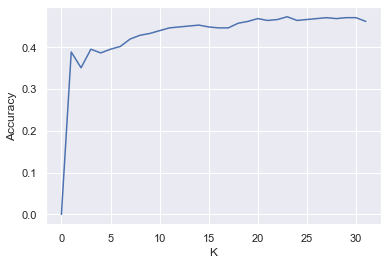

In [16]:
#### Choose best K in KNN --> finally, choose K=30
K = [0]
Acc = [0]
for i in range (1,32):
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_features_std, train_labels['genre'])
    pred = predict(valid_features_std, clf)
    acc = evaluate(valid_labels['genre'], pred)
    K.append(i)
    Acc.append(acc)
plt.plot(K, Acc)
plt.xlabel('K')
plt.ylabel('Accuracy')

In [17]:
## developed 3 algorithms and each of them has two sets of input, one set contains original data and the ohter set contains standardized data

learners = ['gnb', 'gnb_std', 'knn', 'knn_std', 'mlp', 'mlp_std']
accuracy=[]


clf = train('gnb', train_features_aud)
pred = predict(valid_features_aud, clf)
acc = evaluate(valid_labels['genre'], pred)
accuracy.append(acc)

clf = train('gnb', train_features_std)
pred = predict(valid_features_std, clf)
acc = evaluate(valid_labels['genre'], pred)
accuracy.append(acc)

clf = train('knn', train_features_aud)
pred = predict(valid_features_aud, clf)
acc = evaluate(valid_labels['genre'], pred)
accuracy.append(acc)

clf = train('knn', train_features_std)
pred = predict(valid_features_std, clf)
acc = evaluate(valid_labels['genre'], pred)
accuracy.append(acc)

clf = train('mlp', train_features_aud)
pred = predict(valid_features_aud, clf)
acc = evaluate(valid_labels['genre'], pred)
accuracy.append(acc)

clf = train('mlp', train_features_std)
pred = predict(valid_features_std, clf)
acc = evaluate(valid_labels['genre'], pred)
accuracy.append(acc) 



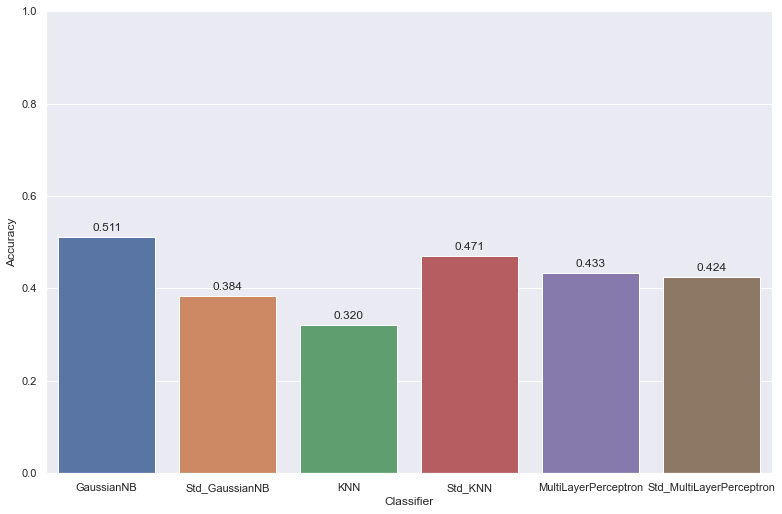

In [18]:
classifiers = ['GaussianNB', 'Std_GaussianNB', 'KNN', 'Std_KNN', 'MultiLayerPerceptron', 'Std_MultiLayerPerceptron']

comparison_figure(classifiers, accuracy)

## Predict Genre from Metadata
### This prediction model performs bad, so we don't put this into our report.

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

#### preprocessing
#### extract Metadata and also have a comparison between standardized input and original input


std_scaler = StandardScaler()

train_features_meta = train_features.loc[:, 'loudness':'duration']
valid_features_meta = valid_features.loc[:, 'loudness':'duration']

train_features_std = std_scaler.fit_transform(train_features_meta)
valid_features_std = std_scaler.fit_transform(valid_features_meta)

In [20]:
def train(tag, X , y = train_labels['genre'], nb_weights = nb_weights):
    if tag == 'gnb':
        clf = GaussianNB()
        clf.fit(X,y,sample_weight=nb_weights)

    elif tag == 'knn':
        clf = KNeighborsClassifier(n_neighbors = 30)
        clf.fit(X,y)
    elif tag == 'mlp':
        clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10, 10, ))
        clf.fit(X,y)
        
    return clf

In [21]:
def predict(X, text_clf):
    return text_clf.predict(X)

def evaluate(y, pred):
    return np.mean(y==pred)

In [22]:
learners = ['gnb', 'gnb_std', 'knn', 'knn_std', 'mlp', 'mlp_std']
accuracy=[]


clf = train('gnb', train_features_meta)
pred = predict(valid_features_meta, clf)
acc = evaluate(valid_labels['genre'], pred)
accuracy.append(acc)

clf = train('gnb', train_features_std)
pred = predict(valid_features_std, clf)
acc = evaluate(valid_labels['genre'], pred)
accuracy.append(acc)

clf = train('knn', train_features_meta)
pred = predict(valid_features_meta, clf)
acc = evaluate(valid_labels['genre'], pred)
accuracy.append(acc)

clf = train('knn', train_features_std)
pred = predict(valid_features_std, clf)
acc = evaluate(valid_labels['genre'], pred)
accuracy.append(acc)

clf = train('mlp', train_features_meta)
pred = predict(valid_features_meta, clf)
acc = evaluate(valid_labels['genre'], pred)
accuracy.append(acc)

clf = train('mlp', train_features_std)
pred = predict(valid_features_std, clf)
acc = evaluate(valid_labels['genre'], pred)
accuracy.append(acc) 

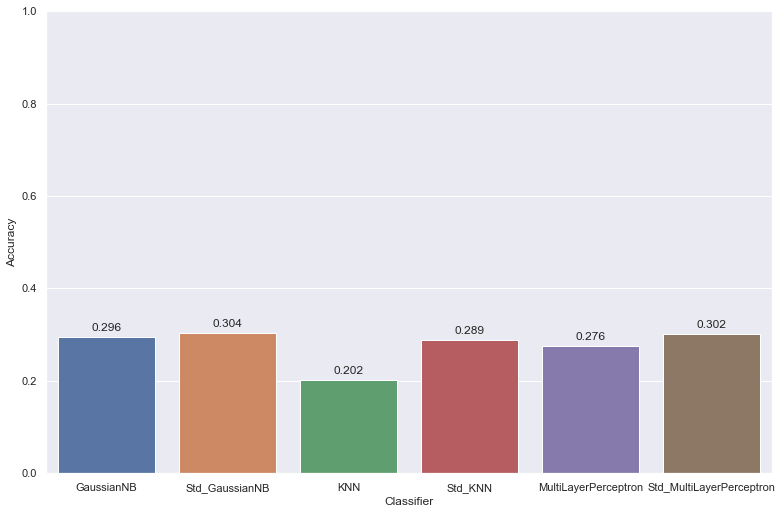

In [23]:
classifiers = ['GaussianNB', 'Std_GaussianNB', 'KNN', 'Std_KNN', 'MultiLayerPerceptron', 'Std_MultiLayerPerceptron']

comparison_figure(classifiers, accuracy)